In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from model.wine_dataset import WineDataset
from model.wine_dataset import WineQualityMLP
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pickle
from pathlib import Path

In [10]:
batch_size = 64

X_train_path = "data/X_train_SMOTE.parquet"
y_train_path = "data/y_train_SMOTE.parquet"
X_test_path = "data/X_test.parquet"
y_test_path = "data/y_test.parquet"

train_dataset = WineDataset(X_train_path, y_train_path)
test_dataset = WineDataset(X_test_path, y_test_path)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cpu


In [12]:
OUT_DIR = Path("model")
epochs = 100
learning_rate = 1e-3
input_size = pd.read_parquet(X_train_path).shape[1]

model = WineQualityMLP(input_size=13).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
with open("model/training_log.csv", "w") as f:
    f.write("epoch,train_loss,rmse,mae,acc,acc_tolerant\n")

best_rmse = float("inf")
patience = 10
counter = 0

for epoch in range(1, epochs + 1):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X_batch.size(0)

    avg_train_loss = total_loss / len(train_loader.dataset)

    # Ewaluacja
    model.eval()
    all_preds, all_targets = [], []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            preds = model(X_batch).cpu().numpy()
            all_preds.extend(preds)
            all_targets.extend(y_batch.numpy())

    rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
    mae = mean_absolute_error(all_targets, all_preds)

    if rmse < best_rmse - 1e-4:
        best_rmse = rmse
        counter = 0
        torch.save(model.state_dict(), OUT_DIR / "best_model.pth")
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    # Accuracy
    all_preds_rounded = np.round(all_preds).astype(int)
    all_targets_int = np.array(all_targets).astype(int)
    acc = (all_preds_rounded == all_targets_int).mean()
    acc_tolerant = (np.abs(all_preds_rounded - all_targets_int) <= 1).mean()

    with open(r"model/training_log.csv", "a") as f:
        f.write(f"{epoch},{avg_train_loss:.4f},{rmse:.4f},{mae:.4f},{acc:.4f},{acc_tolerant:.4f}\n")

    print(f"[{epoch:03d}] Train Loss: {avg_train_loss:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | ACC: {acc:.4f} | ACC±1: {acc_tolerant:.4f}")


[001] Train Loss: 25.7556 | RMSE: 4.5484 | MAE: 4.4655 | ACC: 0.0000 | ACC±1: 0.0000
[002] Train Loss: 12.5582 | RMSE: 3.2548 | MAE: 3.1424 | ACC: 0.0000 | ACC±1: 0.0250
[003] Train Loss: 4.7767 | RMSE: 1.8505 | MAE: 1.6396 | ACC: 0.0906 | ACC±1: 0.4813
[004] Train Loss: 1.7209 | RMSE: 1.1062 | MAE: 0.8551 | ACC: 0.3875 | ACC±1: 0.8406
[005] Train Loss: 1.0978 | RMSE: 0.9429 | MAE: 0.7446 | ACC: 0.4156 | ACC±1: 0.8781
[006] Train Loss: 0.9653 | RMSE: 0.9423 | MAE: 0.7424 | ACC: 0.4125 | ACC±1: 0.8969
[007] Train Loss: 0.9568 | RMSE: 0.9520 | MAE: 0.7642 | ACC: 0.4094 | ACC±1: 0.8719
[008] Train Loss: 0.8902 | RMSE: 0.8613 | MAE: 0.6746 | ACC: 0.4781 | ACC±1: 0.9094
[009] Train Loss: 0.8298 | RMSE: 0.8639 | MAE: 0.6746 | ACC: 0.4750 | ACC±1: 0.9000
[010] Train Loss: 0.8137 | RMSE: 0.8659 | MAE: 0.6869 | ACC: 0.4375 | ACC±1: 0.9062
[011] Train Loss: 0.8225 | RMSE: 0.8133 | MAE: 0.6336 | ACC: 0.5188 | ACC±1: 0.9281
[012] Train Loss: 0.8042 | RMSE: 0.8485 | MAE: 0.6717 | ACC: 0.4531 | ACC±

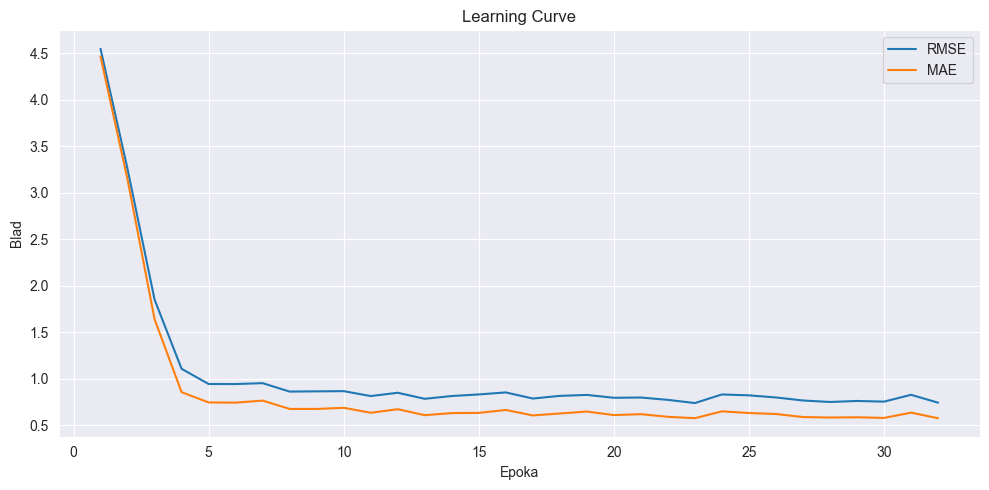

In [14]:
log_df = pd.read_csv("model/training_log.csv")

plt.figure(figsize=(10, 5))
plt.plot(log_df['epoch'], log_df['rmse'], label="RMSE")
plt.plot(log_df['epoch'], log_df['mae'], label="MAE")
plt.title("Learning Curve")
plt.xlabel("Epoka")
plt.ylabel("Blad")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()